### Library imports

In [1]:
# FathomNet 2025 @ CVPR-FGVC Competition
# Taxonomy-Aware Hierarchical Classifier

import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from torchvision.models import convnext_base, ConvNeXt_Base_Weights
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
import torchvision
from collections import defaultdict
warnings.filterwarnings('ignore')


### Configuration

In [2]:
# Path config
DATA_ROOT = "/mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/"

class Config:
    # Paths
    TAXONOMY_PATH = os.path.join(DATA_ROOT, "taxonomy.csv")
    TRAIN_ANNOTATIONS = os.path.join(DATA_ROOT, "train", "annotations.csv")
    TRAIN_IMAGE_DIR = os.path.join(DATA_ROOT, "train", "rois")
    TEST_ANNOTATIONS = os.path.join(DATA_ROOT, "test","annotations.csv")
    TEST_IMAGE_DIR = os.path.join(DATA_ROOT, "test", "rois")
    OUTPUT_DIR = os.path.join(DATA_ROOT, "outputs")
    SUBMISSION_PATH = os.path.join(DATA_ROOT, "submission.csv")
    
    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 8
    MAX_EPOCHS = 50
    LEARNING_RATE = 3e-4
    WEIGHT_DECAY = 0.05
    LABEL_SMOOTHING = 0.1
    
    # Model parameters
    IMG_SIZE = 224
    BACKBONE = "convnext_base"
    
    # Taxonomic levels
    TAXONOMY_LEVELS = ["order", "family", "genus", "species"]
    
    # Inference parameters
    CONFIDENCE_THRESHOLD = 0.7
    
def check_path(path, is_dir=False):
    exists = os.path.exists(path)
    if not exists:
        return f"NOT FOUND: {path}"
    else:
        if is_dir:
            return f"Directory found: {path}"
        else:
            return f"File found: {path}"

print("Checking configured paths:")
print(check_path(Config.TAXONOMY_PATH))
print(check_path(Config.TRAIN_ANNOTATIONS))
print(check_path(Config.TRAIN_IMAGE_DIR, is_dir=True))
print(check_path(Config.TEST_ANNOTATIONS))
print(check_path(Config.TRAIN_IMAGE_DIR, is_dir=True))
print(f"Output will be saved to: {os.path.abspath(Config.OUTPUT_DIR)}")

# Create output directory if it doesn't exist
os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

Checking configured paths:
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/taxonomy.csv
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/annotations.csv
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/rois
File found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/test/annotations.csv
Directory found: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/train/rois
Output will be saved to: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs


### Initialize vars

In [3]:
# Pipeline Control Panel
RUN_EXPLORATION = True       # Explore the dataset
RUN_TRAINING = True          # Train a new model
LOAD_PRETRAINED = False      # Instead of training, load a pretrained model
PRETRAINED_PATH = os.path.join(DATA_ROOT, "outputs", "best_model.ckpt")  # Path to pretrained model if LOAD_PRETRAINED=True
RUN_ANALYSIS = True          # Analyze model performance
GENERATE_SUBMISSION = True   # Generate submission file

# Initialize variables we'll need later
train_loader = None
val_loader = None
test_loader = None
taxonomy_df = None
encoders = None
class_counts = None
id_to_name = None
name_to_id = None
best_model_path = None

### Taxonomy Encoding

In [4]:
def load_and_encode_taxonomy():
    # Load taxonomy data and create encoders for each taxonomic level.
    print("Loading taxonomy data...")
    taxonomy_df = pd.read_csv(Config.TAXONOMY_PATH)
    
    encoders = {}
    class_counts = {}
    id_to_name = {}
    name_to_id = {}
    
    for level in Config.TAXONOMY_LEVELS:
        if level not in taxonomy_df.columns:
            print(f"Warning: '{level}' not found in taxonomy data!")
            continue
            
        le = LabelEncoder()
        taxonomy_df[f"{level}_id"] = le.fit_transform(taxonomy_df[level])
        encoders[level] = le
        class_counts[level] = len(le.classes_)
        id_to_name[level] = {i: name for i, name in enumerate(le.classes_)}
        name_to_id[level] = {name: i for i, name in enumerate(le.classes_)}
        
        print(f"  - {level.capitalize()}: {len(le.classes_)} classes")
    
    return taxonomy_df, encoders, class_counts, id_to_name, name_to_id

def build_taxonomic_lookup(taxonomy_df):
        family_to_order = taxonomy_df.drop_duplicates(["family", "order"]).set_index("family")["order"].to_dict()
        genus_to_family = taxonomy_df.drop_duplicates(["genus", "family"]).set_index("genus")["family"].to_dict()
        species_to_genus = taxonomy_df.drop_duplicates(["species", "genus"]).set_index("species")["genus"].to_dict()
        return species_to_genus, genus_to_family, family_to_order

### Dataset classes

In [5]:
# Build soft target mappings    
def build_species_taxonomy_maps(taxonomy_df):
    species_to_genus = taxonomy_df.set_index("species")["genus"].to_dict()
    species_to_family = taxonomy_df.set_index("species")["family"].to_dict()
    species_to_order = taxonomy_df.set_index("species")["order"].to_dict()

    genus_to_species = defaultdict(set)
    family_to_species = defaultdict(set)
    order_to_species = defaultdict(set)

    for species in taxonomy_df["species"]:
        g = species_to_genus[species]
        f = species_to_family[species]
        o = species_to_order[species]
        genus_to_species[g].add(species)
        family_to_species[f].add(species)
        order_to_species[o].add(species)

    return species_to_genus, species_to_family, species_to_order, genus_to_species, family_to_species, order_to_species

# Build soft targets
def build_soft_species_targets(species_names, encoders, taxonomy_df,
                            α_genus=0.3, α_family=0.1, α_order=0.05):
    num_classes = len(encoders["species"].classes_)
    soft_targets = []

    (species_to_genus, species_to_family, species_to_order,
    genus_to_species, family_to_species, order_to_species) = build_species_taxonomy_maps(taxonomy_df)

    for species in species_names:
        target = torch.zeros(num_classes)

        correct_idx = encoders["species"].transform([species])[0]
        target[correct_idx] = 1.0

        g = species_to_genus.get(species)
        f = species_to_family.get(species)
        o = species_to_order.get(species)

        for s in genus_to_species[g]:
            if s != species:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_genus

        for s in family_to_species[f]:
            if s not in genus_to_species[g]:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_family

        for s in order_to_species[o]:
            if s not in genus_to_species[g] and s not in family_to_species[f]:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_order

        soft_targets.append(target)

    return torch.stack(soft_targets)

In [6]:
class FathomNetTaxonomyDataset(Dataset):
    # Dataset for FathomNet with taxonomic information.    
    def __init__(self, image_paths, species_names, taxonomy_df, encoders, transform=None):
        self.image_paths = image_paths
        self.species_names = species_names
        self.taxonomy_df = taxonomy_df
        self.encoders = encoders
        self.transform = transform
        
        # Pre-compute taxonomic info for faster access
        self.taxonomic_info = []
        for species in species_names:
            row = self.taxonomy_df[self.taxonomy_df['species'] == species]
            if row.empty:
                print(f"Warning: Species '{species}' not found in taxonomy_df")
                # Use a default row
                self.taxonomic_info.append({level: 0 for level in Config.TAXONOMY_LEVELS})
            else:
                row = row.iloc[0]
                self.taxonomic_info.append({
                    level: int(row[f'{level}_id']) for level in Config.TAXONOMY_LEVELS 
                    if f'{level}_id' in row
                })
                
        self.soft_species_targets = build_soft_species_targets(
            species_names, encoders, taxonomy_df
        )

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        # Return image and taxonomic labels
        result = {'image': img}
        result.update(self.taxonomic_info[idx])
        
        return result

class FathomNetTestDataset(Dataset):
    # Dataset for FathomNet test set without labels.
    def __init__(self, image_paths, annotation_ids, transform=None):
        self.image_paths = image_paths
        self.annotation_ids = annotation_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        annotation_id = self.annotation_ids[idx]
        
        # Handle image loading errors gracefully
        try:
            img = Image.open(img_path).convert("RGB")
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Return a black image of the correct size
            img = torch.zeros(3, Config.IMG_SIZE, Config.IMG_SIZE)
        
        return {'image': img, 'annotation_id': annotation_id}

def collate_fn(batch):
    """Custom collate function for training with soft labels."""
    images = torch.stack([b['image'] for b in batch])
    
    # Collect standard integer labels
    labels = {}
    for level in Config.TAXONOMY_LEVELS:
        if level in batch[0]:
            labels[level] = torch.tensor([b[level] for b in batch])

    # Add soft species labels
    if 'soft_species' in batch[0]:
        labels["soft_species"] = torch.stack([b["soft_species"] for b in batch])

    return images, labels

def test_collate_fn(batch):
    """Custom collate function for test dataset."""
    images = torch.stack([b['image'] for b in batch])
    annotation_ids = [b['annotation_id'] for b in batch]
    
    return images, annotation_ids

### Data transformations

In [7]:
def create_transforms():
    # Create augmentation pipelines for train and validation/test sets.
    # Training - strong augmentation to help with model generalization
    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(Config.IMG_SIZE, scale=(0.5, 1.0)),  # Handle size variation
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Validation/Test - just resize and normalize
    val_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

### Hierarchical Neural Network Model

In [8]:
# Define weight shift in later epochs
def get_curriculum_weights(epoch, max_epochs):
    # Linear schedule: weights shift from coarse → fine
    alpha = epoch / max_epochs
    return {
        'order': 1.0 - 0.3 * alpha,     # 1.0 → 0.7
        'family': 1.0 + 0.2 * alpha,    # 1.0 → 1.2
        'genus': 1.5 + 0.5 * alpha,     # 1.5 → 2.0
        'species': 2.0 + 1.0 * alpha,   # 2.0 → 3.0
        'species_indep': 0.5            # non-hierarchal
    }

class TaxonomyAwareClassifier(pl.LightningModule):
    # Classifier that leverages taxonomic hierarchy for marine species classification.
    
    def __init__(self, class_counts, id_to_name=None, species_to_genus=None, genus_to_family=None, family_to_order=None, lr=Config.LEARNING_RATE):
        super().__init__()
        self.save_hyperparameters()
        self.class_counts = class_counts
        self.lr = lr

        # Lookup dictionaries for taxonomy consistency
        self.id_to_name = id_to_name
        self.species_to_genus = species_to_genus
        self.genus_to_family = genus_to_family
        self.family_to_order = family_to_order
    
        # Load pretrained backbone
        weights = ConvNeXt_Base_Weights.DEFAULT
        backbone = convnext_base(weights=weights)
        self.feature_extractor = nn.Sequential(*(list(backbone.children())[:-2]))
        
        # Extract feature dimensions
        in_features = backbone.classifier[2].in_features
        
        # Shared feature network
        self.shared_features = nn.Sequential(
            nn.LayerNorm(in_features),  # Normalize before processing
            nn.Linear(in_features, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
        )
        
        # Independent species head
        self.independent_species_head = nn.Sequential(
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, self.class_counts["species"])
        )

        
        # Create hierarchical network
        self._create_hierarchical_network(class_counts)
        
        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=Config.LABEL_SMOOTHING)
        self.lr = lr
        
        # Track validation metrics
        self.val_step_outputs = []
        
    def _create_hierarchical_network(self, class_counts):
        # Create the hierarchical classification heads.
        # Order classification (top level)
        self.order_head = nn.Linear(1024, class_counts['order'])
        
        # Family classification (conditioned on order)
        self.order_to_family = nn.Linear(class_counts['order'], 512)
        self.family_features = nn.Linear(1024, 512)
        self.family_head = nn.Linear(1024, class_counts['family'])
        
        # Genus classification (conditioned on family)
        self.family_to_genus = nn.Linear(class_counts['family'], 512)
        self.genus_features = nn.Linear(1024, 512)
        self.genus_head = nn.Linear(1024, class_counts['genus'])
        
        # Species classification (conditioned on genus)
        self.genus_to_species = nn.Linear(class_counts['genus'], 512)
        self.species_features = nn.Linear(1024, 512)
        self.species_head = nn.Linear(1024, class_counts['species'])
    
    def forward(self, x):
        # Forward pass through the network.
        # Extract features from the backbone
        features = self.feature_extractor(x)
        features = nn.functional.adaptive_avg_pool2d(features, (1, 1)).squeeze(-1).squeeze(-1)
        
        # Apply shared feature processing
        shared = self.shared_features(features)
        
        # Order prediction (highest level)
        order_logits = self.order_head(shared)
        order_probs = torch.softmax(order_logits, dim=1)
        
        # Family prediction (conditioned on order)
        family_from_order = self.order_to_family(order_probs)
        family_from_features = self.family_features(shared)
        family_combined = torch.cat([family_from_order, family_from_features], dim=1)
        family_logits = self.family_head(family_combined)
        family_probs = torch.softmax(family_logits, dim=1)
        
        # Genus prediction (conditioned on family)
        genus_from_family = self.family_to_genus(family_probs)
        genus_from_features = self.genus_features(shared)
        genus_combined = torch.cat([genus_from_family, genus_from_features], dim=1)
        genus_logits = self.genus_head(genus_combined)
        genus_probs = torch.softmax(genus_logits, dim=1)
        
        # Species prediction (conditioned on genus)
        species_from_genus = self.genus_to_species(genus_probs)
        species_from_features = self.species_features(shared)
        species_combined = torch.cat([species_from_genus, species_from_features], dim=1)
        species_logits = self.species_head(species_combined)
        
        # Species prediction (independent)
        independent_species_logits = self.independent_species_head(shared)
        
        # Return logits for each taxonomic level
        return {
            'order': order_logits,
            'family': family_logits,
            'genus': genus_logits,
            'species': species_logits, # conditioned
            'species_indep': independent_species_logits # independent
        }
    
    # Taxanomic regularization penalty
    def compute_taxonomic_inconsistency_penalty(self, outputs):
        penalty = 0.0
        batch_size = outputs["species"].shape[0]

        pred_species = torch.argmax(outputs["species"], dim=1).cpu().tolist()
        pred_genus = torch.argmax(outputs["genus"], dim=1).cpu().tolist()
        pred_family = torch.argmax(outputs["family"], dim=1).cpu().tolist()
        pred_order = torch.argmax(outputs["order"], dim=1).cpu().tolist()

        for i in range(batch_size):
            species = self.id_to_name["species"].get(pred_species[i])
            genus = self.id_to_name["genus"].get(pred_genus[i])
            family = self.id_to_name["family"].get(pred_family[i])
            order = self.id_to_name["order"].get(pred_order[i])

            if not (species and genus and family and order):
                continue  # skip unknowns

            expected_genus = self.species_to_genus.get(species)
            expected_family = self.genus_to_family.get(genus)
            expected_order = self.family_to_order.get(family)

            if expected_genus != genus:
                penalty += 1.0
            if expected_family != family:
                penalty += 1.0
            if expected_order != order:
                penalty += 1.0

        return penalty / batch_size

    def hierarchical_loss(self, outputs, targets, epoch=None, max_epochs=None):
        # Calculate hierarchical loss with dynamic curriculum weights
        losses = {}
        total_loss = 0.0
        
        # Curriculum-aware weights
        if epoch is not None and max_epochs is not None:
            weights = get_curriculum_weights(epoch, max_epochs)
        else:
            weights = {'order': 1.0, 'family': 1.5, 'genus': 2.0, 'species': 2.5, 'species_indep': 0.5}

        if "species_indep" in outputs:
            indep_loss = self.criterion(outputs["species_indep"], targets["species"])
            losses["species_indep"] = indep_loss
            total_loss += 0.5 * indep_loss

        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in targets:
                if level == "species" and "soft_species" in targets:
                    log_probs = torch.log_softmax(outputs[level], dim=1)
                    level_loss = -(targets["soft_species"].to(log_probs.device) * log_probs).sum(dim=1).mean()
                else:
                    level_loss = self.criterion(outputs[level], targets[level])
                losses[level] = level_loss
                total_loss += weights[level] * level_loss
        
        total_weight = sum(weights[l] for l in losses.keys())
        
        return total_loss / total_weight, losses

    def training_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch

        # Forward pass
        outputs = self(x)

        # Get current epoch and max epochs
        epoch = self.current_epoch
        max_epochs = self.trainer.max_epochs

        # Compute dynamically weighted hierarchical loss
        loss, level_losses = self.hierarchical_loss(outputs, y, epoch=epoch, max_epochs=max_epochs)
        
        # Taxonomy penalty
        tax_penalty = self.compute_taxonomic_inconsistency_penalty(outputs)
        total_loss = loss + 0.2 * tax_penalty  # you can tune 0.2 later

        # Log loss
        self.log("train_loss", total_loss, prog_bar=True)
        self.log("taxonomy_penalty", tax_penalty, prog_bar=False)

        # Log individual level losses
        for level, level_loss in level_losses.items():
            self.log(f"train_{level}_loss", level_loss, prog_bar=False)

        # (Optional) Log the curriculum weights for transparency/debugging
        weights = get_curriculum_weights(epoch, max_epochs)
        for level, w in weights.items():
            self.log(f"weight_{level}", w, prog_bar=False)

        return total_loss

    def validation_step(self, batch, batch_idx):
        # Unpack batch
        x, y = batch
        
        # Forward pass
        outputs = self(x)
        
        # Calculate loss
        loss, level_losses = self.hierarchical_loss(outputs, y)
        
        # Calculate accuracy for each level
        accuracy = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs and level in y:
                preds = torch.argmax(outputs[level], dim=1)
                acc = (preds == y[level]).float().mean()
                accuracy[level] = acc
        
        # Log metrics
        self.log("val_loss", loss, prog_bar=True, sync_dist=True)
        for level, level_loss in level_losses.items():
            self.log(f"val_{level}_loss", level_loss, prog_bar=False, sync_dist=True)
            
        for level, acc in accuracy.items():
            self.log(f"val_{level}_acc", acc, prog_bar=True, sync_dist=True)
        
        # Store outputs for epoch end processing
        self.val_step_outputs.append({
            'outputs': outputs,
            'targets': y
        })
        
        return loss
    
    def on_validation_epoch_end(self):
        # Skip if no validation steps were performed
        if not self.val_step_outputs:
            return
        
        # Collect all predictions and targets
        all_preds = {level: [] for level in Config.TAXONOMY_LEVELS}
        all_targets = {level: [] for level in Config.TAXONOMY_LEVELS}
        
        for output in self.val_step_outputs:
            for level in Config.TAXONOMY_LEVELS:
                if level in output['outputs'] and level in output['targets']:
                    pred = torch.argmax(output['outputs'][level], dim=1).cpu()
                    target = output['targets'][level].cpu()
                    all_preds[level].append(pred)
                    all_targets[level].append(target)
        
        # Concatenate predictions and targets
        for level in Config.TAXONOMY_LEVELS:
            if all_preds[level]:
                all_preds[level] = torch.cat(all_preds[level])
                all_targets[level] = torch.cat(all_targets[level])
        
        # Calculate overall accuracy for each level
        for level in Config.TAXONOMY_LEVELS:
            if len(all_preds[level]) > 0:
                acc = (all_preds[level] == all_targets[level]).float().mean()
                self.log(f"val_{level}_acc_epoch", acc, prog_bar=True)
        
        # Clear stored outputs
        self.val_step_outputs.clear()
    
    def predict_step(self, batch, batch_idx):
        # Generate predictions for test data
        # Handle both batched images and (images, _) tuples
        if isinstance(batch, tuple) and len(batch) == 2:
            images, annotation_ids = batch
        else:
            images = batch
            annotation_ids = None
        
        # Forward pass
        outputs = self(images)
        
        # Get probabilities and predictions for each level
        results = {}
        for level in Config.TAXONOMY_LEVELS:
            if level in outputs:
                probs = torch.softmax(outputs[level], dim=1)
                preds = torch.argmax(probs, dim=1)
                conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)
                
                results[level] = {
                    'pred': preds.cpu(),
                    'conf': conf.cpu(),
                    'probs': probs.cpu()
                }
        
        if annotation_ids is not None:
            results['annotation_ids'] = annotation_ids
            
        return results
    
    def configure_optimizers(self):
        # Configure optimizers with different learning rates for backbone vs heads
        # Group parameters by part of the model
        backbone_params = self.feature_extractor.parameters()
        classifier_params = [p for n, p in self.named_parameters() 
                            if "feature_extractor" not in n]
        
        # Create parameter groups with different learning rates
        param_groups = [
            {'params': backbone_params, 'lr': self.lr / 10},  # Lower LR for backbone
            {'params': classifier_params, 'lr': self.lr}
        ]
        
        # Create optimizer
        optimizer = torch.optim.AdamW(param_groups, weight_decay=Config.WEIGHT_DECAY)
        
        # Create learning rate scheduler
        scheduler = {
            "scheduler": torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer, T_0=5, T_mult=2, eta_min=1e-6
            ),
            "interval": "epoch",
            "frequency": 1,
        }
        
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

### Data preparation

In [9]:
def prepare_data():
    # Prepare datasets and dataloaders
    print("Preparing datasets...")
    
    # Load annotations
    annotations = pd.read_csv(Config.TRAIN_ANNOTATIONS)
    image_paths = [os.path.join(Config.TRAIN_IMAGE_DIR, p) for p in annotations['path']]
    species_names = annotations['label'].tolist()
    
    # Create train/val splits
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_idx, val_idx = next(sss.split(image_paths, species_names))
    
    # Get paths and labels for each split
    train_paths = [image_paths[i] for i in train_idx]
    train_species = [species_names[i] for i in train_idx]
    
    val_paths = [image_paths[i] for i in val_idx]
    val_species = [species_names[i] for i in val_idx]
    
    # Create transforms
    train_transform, val_transform = create_transforms()
    
    # Load taxonomy data
    taxonomy_df, encoders, class_counts, id_to_name, name_to_id = load_and_encode_taxonomy()
    
    # Create datasets
    train_dataset = FathomNetTaxonomyDataset(
        train_paths, train_species, taxonomy_df, encoders, transform=train_transform
    )
    
    val_dataset = FathomNetTaxonomyDataset(
        val_paths, val_species, taxonomy_df, encoders, transform=val_transform
    )
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=True, 
        num_workers=Config.NUM_WORKERS, 
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=Config.NUM_WORKERS, 
        collate_fn=collate_fn,
        pin_memory=True
    )
    
    print(f"Train dataset: {len(train_dataset)} images")
    print(f"Validation dataset: {len(val_dataset)} images")
    
    return train_loader, val_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id

### Training function

In [10]:
def train_model(train_loader, val_loader, class_counts):
    # Train the model using PyTorch Lightning.    
    print("Starting model training...")
    
    # Create model
    model = TaxonomyAwareClassifier(
        class_counts=class_counts,
        id_to_name=id_to_name,
        species_to_genus=species_to_genus,
        genus_to_family=genus_to_family,
        family_to_order=family_to_order
    )

    # Create callbacks
    checkpoint_callback = ModelCheckpoint(
        dirpath=Config.OUTPUT_DIR,
        filename='fathomnet-{epoch:02d}-{val_loss:.4f}',
        save_top_k=3,
        monitor='val_loss',
        mode='min'
    )
    
    early_stop_callback = EarlyStopping(
        monitor='val_loss',
        patience=10,
        mode='min'
    )
    
    lr_monitor = LearningRateMonitor(logging_interval='epoch')
    
    # Create trainer
    trainer = pl.Trainer(
        max_epochs=Config.MAX_EPOCHS,
        accelerator="gpu",
        devices=1,
        precision=16,  # Mixed precision for faster training
        callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
        log_every_n_steps=10,
        default_root_dir=Config.OUTPUT_DIR
    )
    
    # Train model
    trainer.fit(model, train_loader, val_loader)
    
    # Return best model path
    return checkpoint_callback.best_model_path

### Test Data Preparation

In [11]:
def prepare_test_data(taxonomy_df):
    """Prepare test dataset and dataloader."""
    
    print("Preparing test dataset...")
    
    # Load test annotations
    test_annotations = pd.read_csv(Config.TEST_ANNOTATIONS)
    test_image_paths = [os.path.join(Config.TEST_IMAGE_DIR, p) for p in test_annotations['path']]
    
    # Use row indices as IDs since there's no annotation_id column
    test_annotation_ids = list(range(len(test_annotations)))
    
    print(f"Using row indices (0 to {len(test_annotations)-1}) as annotation IDs")
    
    # Create transforms
    _, test_transform = create_transforms()
    
    # Create test dataset
    test_dataset = FathomNetTestDataset(
        test_image_paths, test_annotation_ids, transform=test_transform
    )
    
    # Create test dataloader
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.BATCH_SIZE, 
        shuffle=False, 
        num_workers=Config.NUM_WORKERS, 
        collate_fn=test_collate_fn
    )
    
    print(f"Test dataset: {len(test_dataset)} images")
    
    return test_loader

### Inference and submission

In [13]:
taxonomy_df = pd.read_csv("taxonomy.csv")
taxonomy_df = taxonomy_df.dropna(subset=["species"])  # filter nulls


In [14]:
# Map from genus/family/order to most common species
genus_to_species = defaultdict(str)
family_to_species = defaultdict(str)
order_to_species = defaultdict(str)

# Group by and use first listed species (or most frequent, if you want more logic)
for level, mapping in [("genus", genus_to_species),
                       ("family", family_to_species),
                       ("order", order_to_species)]:
    
    grouped = taxonomy_df.groupby(level)["species"].agg(lambda x: x.value_counts().idxmax())
    
    for k, v in grouped.items():
        mapping[k] = v

print("Fallback mappings created.")


Fallback mappings created.


In [15]:
def get_taxonomic_prediction(outputs, id_to_name, confidence_threshold, taxonomy_df):
    # Build fallback maps
    genus_map = taxonomy_df.groupby("genus")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    family_map = taxonomy_df.groupby("family")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    order_map = taxonomy_df.groupby("order")["species"].agg(lambda x: x.value_counts().idxmax()).to_dict()
    
    predictions = {}
    confidences = {}
    
    for level in Config.TAXONOMY_LEVELS:
        preds = outputs[level]["pred"]
        confs = outputs[level]["conf"]
        predictions[level] = preds.tolist() if isinstance(preds, torch.Tensor) else preds
        confidences[level] = confs.tolist() if isinstance(confs, torch.Tensor) else confs

    id_to_name = {level: {int(k): str(v) for k, v in id_to_name[level].items()} for level in Config.TAXONOMY_LEVELS}
    
    best_names = []

    for i in range(len(predictions["order"])):
        # Try species directly
        species_id = predictions["species"][i]
        species_conf = confidences["species"][i]
        species_name = id_to_name["species"].get(species_id)

        if species_name and species_conf >= confidence_threshold:
            best_names.append(species_name)
            continue

        # Try genus → species
        genus_id = predictions["genus"][i]
        genus_name = id_to_name["genus"].get(genus_id)
        fallback_species = genus_map.get(genus_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Try family → species
        family_id = predictions["family"][i]
        family_name = id_to_name["family"].get(family_id)
        fallback_species = family_map.get(family_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Try order → species
        order_id = predictions["order"][i]
        order_name = id_to_name["order"].get(order_id)
        fallback_species = order_map.get(order_name)

        if fallback_species:
            best_names.append(fallback_species)
            continue

        # Final fallback: unknown
        best_names.append("fallback_species_unknown")

    return best_names


def generate_submission(model_path, test_loader, class_counts, id_to_name, taxonomy_df, taxonomic_mapping=None):
    """Generate submission file for the competition with dual-species-head logic."""
    print("Generating submission file...")

    # Load the model
    model = TaxonomyAwareClassifier.load_from_checkpoint(
        model_path,
        class_counts=class_counts,
        id_to_name=id_to_name,
        species_to_genus=species_to_genus,
        genus_to_family=genus_to_family,
        family_to_order=family_to_order
    )
    model.eval()

    # Device setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Running inference on: {device}")
    model.to(device)

    # Fixed learned temperature
    learned_temp = 1.0907

    # Output containers
    all_annotation_ids = []
    all_predictions = {level: [] for level in Config.TAXONOMY_LEVELS}
    all_confidences = {level: [] for level in Config.TAXONOMY_LEVELS}

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Processing test data"):
            images, annotation_ids = batch
            images = images.to(device)

            # Inference
            outputs = model(images)
            all_annotation_ids.extend(annotation_ids)

            for level in Config.TAXONOMY_LEVELS:
                if level in outputs:
                    if level == "species":
                        # Calibrated conditioned species
                        cond_logits = outputs["species"] / learned_temp
                        cond_probs = torch.softmax(cond_logits, dim=1)
                        cond_conf, cond_pred = cond_probs.max(dim=1)

                        # Calibrated independent species
                        indep_logits = outputs["species_indep"] / learned_temp
                        indep_probs = torch.softmax(indep_logits, dim=1)
                        indep_conf, indep_pred = indep_probs.max(dim=1)

                        # Hybrid decision: use conditioned if confidence is high enough
                        final_pred = torch.where(
                            cond_conf >= Config.CONFIDENCE_THRESHOLD,
                            cond_pred,
                            indep_pred
                        )
                        final_conf = torch.where(
                            cond_conf >= Config.CONFIDENCE_THRESHOLD,
                            cond_conf,
                            indep_conf
                        )

                        all_predictions[level].extend(final_pred.cpu().numpy())
                        all_confidences[level].extend(final_conf.cpu().numpy())

                    else:
                        # Normal path for order/family/genus
                        probs = torch.softmax(outputs[level], dim=1)
                        preds = torch.argmax(probs, dim=1)
                        conf = torch.gather(probs, 1, preds.unsqueeze(1)).squeeze(1)

                        all_predictions[level].extend(preds.cpu().numpy())
                        all_confidences[level].extend(conf.cpu().numpy())

    # Get final species names using fallback
    best_names = get_taxonomic_prediction(
        {
            'order': {'pred': all_predictions['order'], 'conf': all_confidences['order']},
            'family': {'pred': all_predictions['family'], 'conf': all_confidences['family']},
            'genus': {'pred': all_predictions['genus'], 'conf': all_confidences['genus']},
            'species': {'pred': all_predictions['species'], 'conf': all_confidences['species']}
        },
        id_to_name,
        confidence_threshold=Config.CONFIDENCE_THRESHOLD,
        taxonomy_df=taxonomy_df
    )

    # Optional: map names
    if taxonomic_mapping is not None:
        best_names = [taxonomic_mapping.get(name, name) for name in best_names]

    # Save submission
    submission_df = pd.DataFrame({
        'annotation_id': [id + 1 for id in all_annotation_ids],
        'concept_name': best_names
    })
    submission_df.to_csv(Config.SUBMISSION_PATH, index=False)
    print(f"Submission saved to {Config.SUBMISSION_PATH}")

    # Distribution summary
    print("\nPrediction distribution:")
    value_counts = submission_df['concept_name'].value_counts().head(10)
    for name, count in value_counts.items():
        print(f"  {name}: {count} ({count/len(submission_df)*100:.1f}%)")

    return submission_df


### Exploratory Data Analysis

In [16]:
def explore_dataset():
    # Perform exploratory analysis on the dataset    
    # Load annotations
    annotations = pd.read_csv(Config.TRAIN_ANNOTATIONS)
    
    print(f"Training dataset: {len(annotations)} images")
    print(f"Number of unique labels: {annotations['label'].nunique()}")
    
    # Plot label distribution
    plt.figure(figsize=(12, 6))
    top_labels = annotations['label'].value_counts().head(20)
    sns.barplot(x=top_labels.values, y=top_labels.index)
    plt.title('Top 20 Species in Training Set')
    plt.xlabel('Count')
    plt.tight_layout()
    plt.show()
    
    # Load test annotations if available
    try:
        test_annotations = pd.read_csv(Config.TEST_ANNOTATIONS)
        print(f"\nTest dataset: {len(test_annotations)} images")
        
        # Check if test annotations contain labels
        if 'label' in test_annotations.columns:
            print(f"Number of unique test labels: {test_annotations['label'].nunique()}")
            
            # Plot test label distribution
            plt.figure(figsize=(12, 6))
            top_test_labels = test_annotations['label'].value_counts().head(20)
            sns.barplot(x=top_test_labels.values, y=top_test_labels.index)
            plt.title('Top 20 Species in Test Set')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()
    except:
        print("Test annotations not available or could not be loaded.")
    
    # Check a few images
    print("\nVisualizing sample images...")
    image_dir = Config.TRAIN_IMAGE_DIR
    
    plt.figure(figsize=(15, 10))
    sample_indices = np.random.choice(len(annotations), 6, replace=False)
    
    for i, idx in enumerate(sample_indices):
        img_path = os.path.join(image_dir, annotations.iloc[idx]['path'])
        try:
            img = Image.open(img_path).convert("RGB")
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(annotations.iloc[idx]['label'])
            plt.axis('off')
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()
    
    # Check image sizes
    print("\nAnalyzing image sizes...")
    widths = []
    heights = []
    
    for i in range(min(100, len(annotations))):  # Sample 100 images
        img_path = os.path.join(image_dir, annotations.iloc[i]['path'])
        try:
            img = Image.open(img_path)
            widths.append(img.width)
            heights.append(img.height)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20)
    plt.title('Width Distribution')
    plt.xlabel('Width (pixels)')
    
    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20)
    plt.title('Height Distribution')
    plt.xlabel('Height (pixels)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Median width: {np.median(widths)}, Median height: {np.median(heights)}")
    
    return annotations

### Run exploration and prepare data

Starting exploratory data analysis...
Training dataset: 23699 images
Number of unique labels: 79


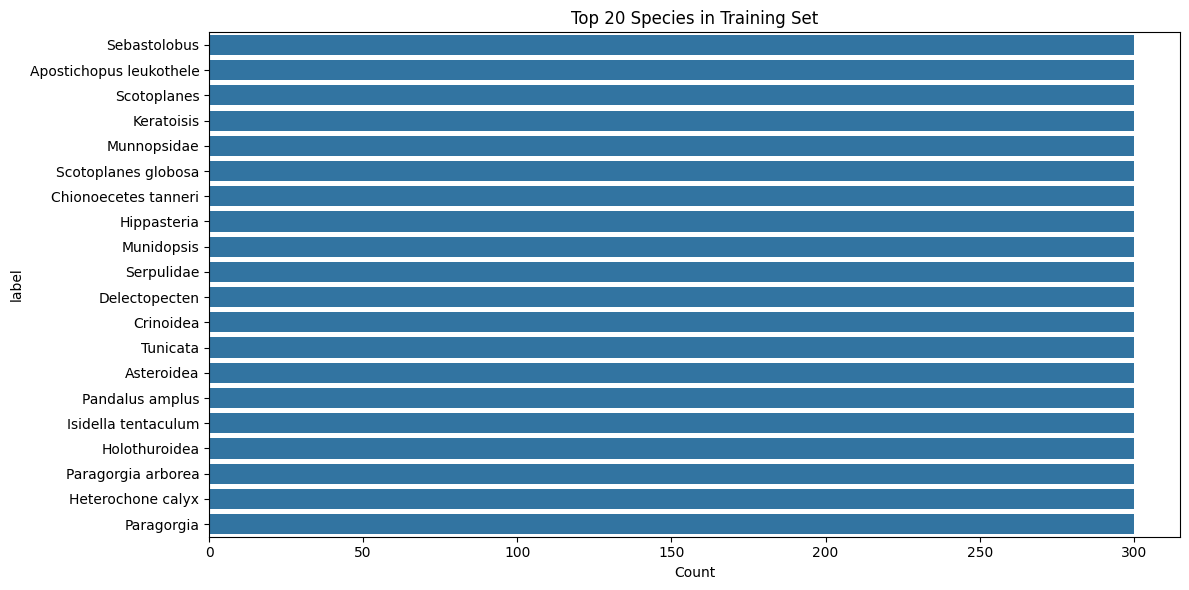


Test dataset: 788 images
Number of unique test labels: 0


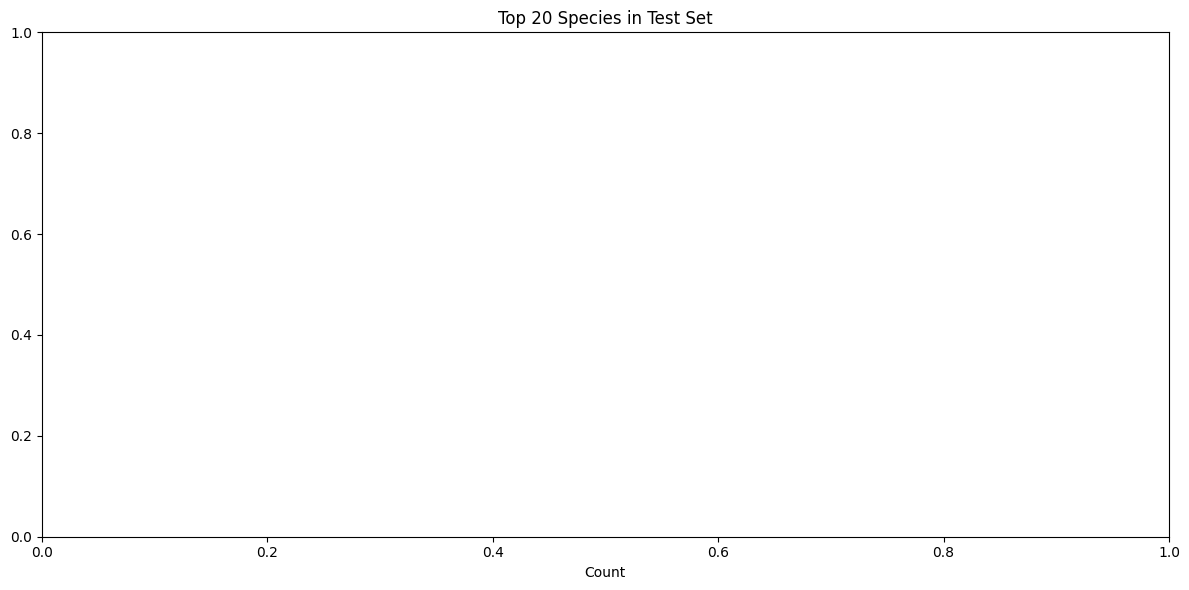


Visualizing sample images...


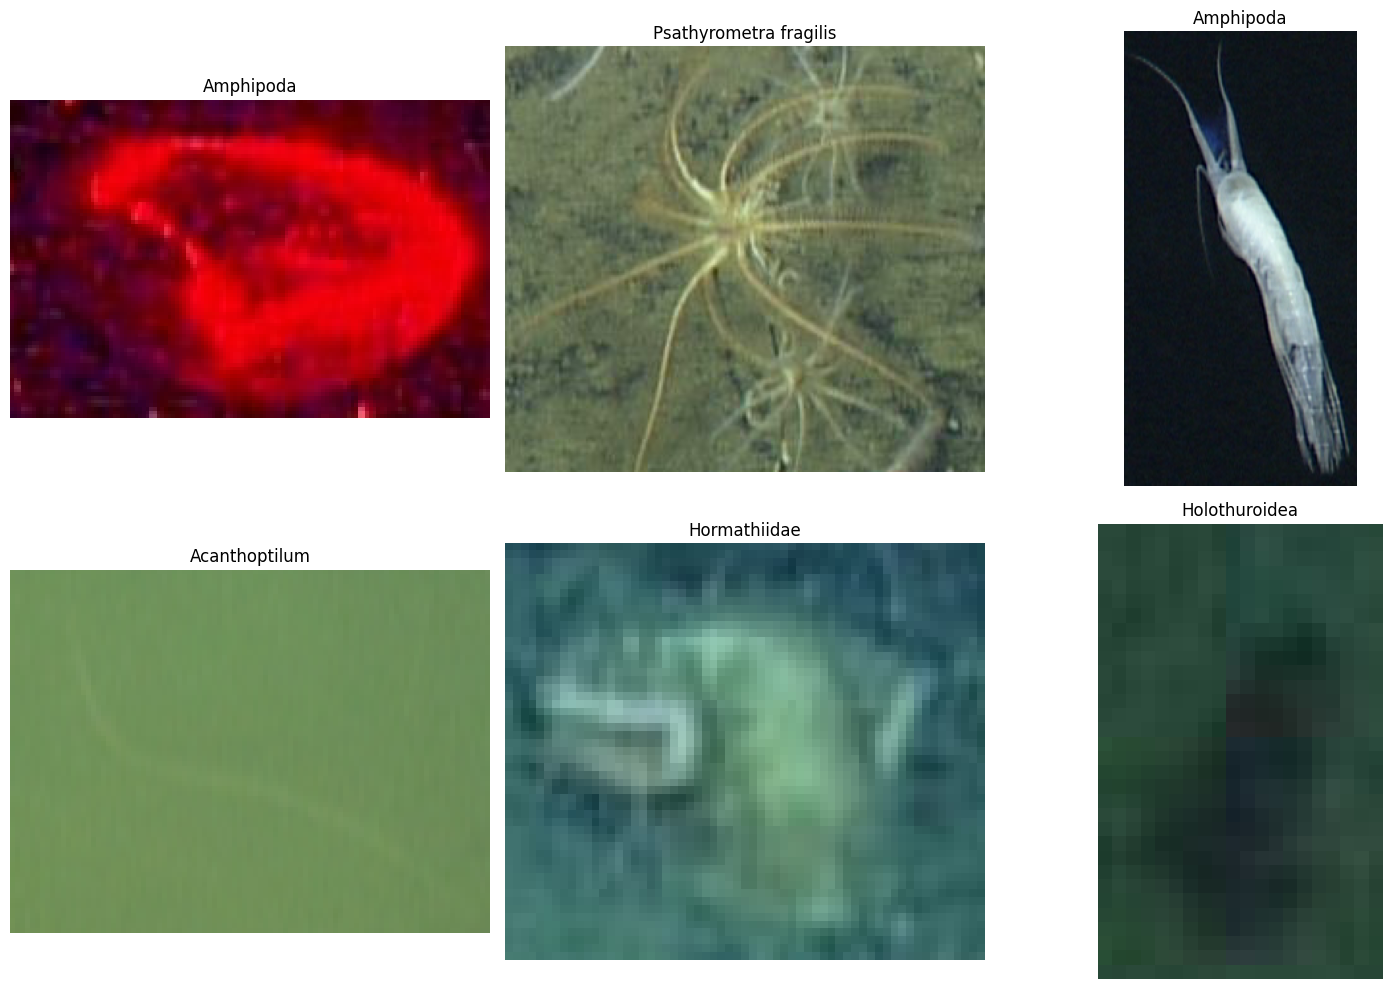


Analyzing image sizes...


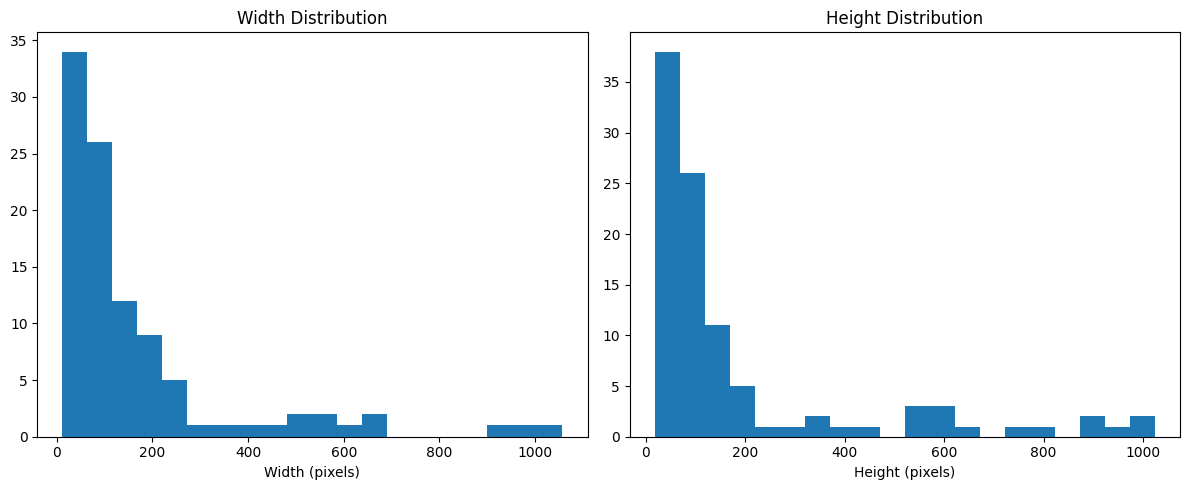

Median width: 97.5, Median height: 86.0

PREPARING TRAINING DATA
Preparing datasets...
Loading taxonomy data...
  - Order: 42 classes
  - Family: 65 classes
  - Genus: 74 classes
  - Species: 79 classes
Train dataset: 18959 images
Validation dataset: 4740 images


In [17]:
# Run data exploration
if RUN_EXPLORATION:
    print("Starting exploratory data analysis...")
    train_annotations = explore_dataset()
else:
    print("Skipping data exploration...")

# Always prepare training data (needed for taxonomy info)
print("\n" + "="*50)
print("PREPARING TRAINING DATA")
print("="*50)
train_loader, val_loader, taxonomy_df, encoders, class_counts, id_to_name, name_to_id = prepare_data()

In [18]:
if RUN_TRAINING:
    # Train the model (this will take time!)
    print("\n" + "="*50)
    print("STARTING MODEL TRAINING")
    print("="*50 + "\n")
    # Build taxonomy lookup
    species_to_genus, genus_to_family, family_to_order = build_taxonomic_lookup(taxonomy_df)
    best_model_path = train_model(train_loader, val_loader, class_counts)
    print(f"Best model saved at: {best_model_path}")
elif LOAD_PRETRAINED:
    # Load a pretrained model
    print("\n" + "="*50)
    print(f"LOADING PRETRAINED MODEL: {PRETRAINED_PATH}")
    print("="*50 + "\n")
    # Build taxonomy lookup
    species_to_genus, genus_to_family, family_to_order = build_taxonomic_lookup(taxonomy_df)
    best_model_path = PRETRAINED_PATH
    
    # Verify the model exists
    if not os.path.exists(best_model_path):
        print(f"ERROR: Pretrained model not found at {best_model_path}")
        # Create a placeholder to avoid errors in later cells
        best_model_path = None
else:
    print("Skipping model training and not loading pretrained model...")
    # Skip both training and loading pretrained
    best_model_path = None


STARTING MODEL TRAINING

Starting model training...


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA H200') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

   | Name                     | Type             | Params | Mode 
-----------------------------------------------------------------------
0  | feature_extractor        | Sequential       | 87.6 M | train
1  | shared_features          | Sequential       | 1.1 M  | train
2  | independent_species_head | Sequential       | 565 K  | train
3  | order_head               | Linear           | 43.1 K | train
4  | order_to_family         

Epoch 24: 100%|██████████| 593/593 [00:30<00:00, 19.59it/s, v_num=3, train_loss=0.876, val_loss=1.170, val_order_acc=0.902, val_family_acc=0.883, val_genus_acc=0.876, val_species_acc=0.869, val_order_acc_epoch=0.902, val_family_acc_epoch=0.883, val_genus_acc_epoch=0.876, val_species_acc_epoch=0.869]
Best model saved at: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/outputs/fathomnet-epoch=14-val_loss=1.1154.ckpt


### Learn temperature

In [19]:
import torch.nn.functional as F

# Fit temperature on validation logits
def collect_validation_logits(model, val_loader, device):
    model.eval()
    all_logits = []
    all_targets = []

    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            outputs = model(x.to(device))
            logits = outputs["species"]
            labels = y["species"]
            all_logits.append(logits.cpu())
            all_targets.append(labels.cpu())

    return torch.cat(all_logits), torch.cat(all_targets)

class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)

    def forward(self, logits):
        return logits / self.temperature

def fit_temperature(logits, labels):
    scaler = TemperatureScaler()
    optimizer = torch.optim.LBFGS([scaler.temperature], lr=0.01, max_iter=50)

    def closure():
        optimizer.zero_grad()
        loss = F.cross_entropy(scaler(logits), labels)
        loss.backward()
        return loss

    optimizer.step(closure)
    return scaler.temperature.item()


In [23]:
# Load model onto device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TaxonomyAwareClassifier.load_from_checkpoint(best_model_path, class_counts=class_counts).to(device)

# Collect logits/targets and fit temperature
val_logits, val_targets = collect_validation_logits(model, val_loader, device)
learned_temp = fit_temperature(val_logits, val_targets)
print(f"Learned temperature: {learned_temp:.4f}")


Learned temperature: 1.0914


### Generate submission

In [24]:
# Generate submission if we have a model
if GENERATE_SUBMISSION and best_model_path is not None:
    print("\n" + "="*50)
    print("PREPARING TEST DATA")
    print("="*50)
    test_loader = prepare_test_data(taxonomy_df)

    # Generate submission
    print("\n" + "="*50)
    print("GENERATING SUBMISSION")          
    print("="*50)
    
    submission_df = generate_submission(
        model_path=best_model_path,
        test_loader=test_loader,
        class_counts=class_counts,
        id_to_name=id_to_name,
        taxonomy_df=taxonomy_df
    )
    
    print(f"\nSubmission saved to: {Config.SUBMISSION_PATH}")
    print(f"Top submission classes:")
    print(submission_df['concept_name'].value_counts().head(10))
else:
    if best_model_path is None:
        print("Skipping submission generation: No model available")
    else:
        print("Skipping submission generation...")


PREPARING TEST DATA
Preparing test dataset...
Using row indices (0 to 787) as annotation IDs
Test dataset: 788 images

GENERATING SUBMISSION
Generating submission file...
Running inference on: cuda


Processing test data: 100%|██████████| 25/25 [00:01<00:00, 18.33it/s]


Submission saved to /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/submission.csv

Prediction distribution:
  Acanthoptilum: 25 (3.2%)
  Porifera: 24 (3.0%)
  Actiniaria: 20 (2.5%)
  Paragorgia: 20 (2.5%)
  Keratoisis: 20 (2.5%)
  Umbellula: 18 (2.3%)
  Ophiuroidea: 17 (2.2%)
  Benthocodon pedunculata: 16 (2.0%)
  Elpidia: 15 (1.9%)
  Florometra serratissima: 15 (1.9%)

Submission saved to: /mnt/beegfs/home/dzimmerman2021/Documents/fathomnet/submission.csv
Top submission classes:
concept_name
Acanthoptilum              25
Porifera                   24
Actiniaria                 20
Paragorgia                 20
Keratoisis                 20
Umbellula                  18
Ophiuroidea                17
Benthocodon pedunculata    16
Elpidia                    15
Florometra serratissima    15
Name: count, dtype: int64


In [25]:
import os
import subprocess
import shutil

os.environ['KAGGLE_USERNAME'] = "****************"
os.environ['KAGGLE_KEY'] = "****************"

kaggle_path = shutil.which("kaggle")

result = subprocess.run([
    kaggle_path, "competitions", "submit", 
    "-c", "fathomnet-2025", 
    "-f", "submission.csv", 
    "-m", "Auto-submission"
], capture_output=True, text=True)
# Build soft target mappings    
def build_species_taxonomy_maps(taxonomy_df):
    species_to_genus = taxonomy_df.set_index("species")["genus"].to_dict()
    species_to_family = taxonomy_df.set_index("species")["family"].to_dict()
    species_to_order = taxonomy_df.set_index("species")["order"].to_dict()

    genus_to_species = defaultdict(set)
    family_to_species = defaultdict(set)
    order_to_species = defaultdict(set)

    for species in taxonomy_df["species"]:
        g = species_to_genus[species]
        f = species_to_family[species]
        o = species_to_order[species]
        genus_to_species[g].add(species)
        family_to_species[f].add(species)
        order_to_species[o].add(species)

    return species_to_genus, species_to_family, species_to_order, genus_to_species, family_to_species, order_to_species

# Build soft targets
def build_soft_species_targets(species_names, encoders, taxonomy_df,
                            α_genus=0.3, α_family=0.1, α_order=0.05):
    num_classes = len(encoders["species"].classes_)
    soft_targets = []

    (species_to_genus, species_to_family, species_to_order,
    genus_to_species, family_to_species, order_to_species) = build_species_taxonomy_maps(taxonomy_df)

    for species in species_names:
        target = torch.zeros(num_classes)

        correct_idx = encoders["species"].transform([species])[0]
        target[correct_idx] = 1.0

        g = species_to_genus.get(species)
        f = species_to_family.get(species)
        o = species_to_order.get(species)

        for s in genus_to_species[g]:
            if s != species:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_genus

        for s in family_to_species[f]:
            if s not in genus_to_species[g]:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_family

        for s in order_to_species[o]:
            if s not in genus_to_species[g] and s not in family_to_species[f]:
                idx = encoders["species"].transform([s])[0]
                target[idx] = α_order

        soft_targets.append(target)

    return torch.stack(soft_targets)
print("STDOUT:\n", result.stdout)
print("STDERR:\n", result.stderr)

if result.returncode != 0:
    print("Submission failed.")
else:
    print("Submission succeeded.")


STDOUT:
 Successfully submitted to FathomNet 2025 @ CVPR-FGVC
STDERR:
 
  0%|          | 0.00/14.4k [00:00<?, ?B/s]
100%|██████████| 14.4k/14.4k [00:00<00:00, 63.4kB/s]

Submission succeeded.


In [26]:
import pandas as pd

df = pd.read_csv("submission.csv")

# Basic structure checks
assert list(df.columns) == ["annotation_id", "concept_name"], "Wrong column headers"
assert df["annotation_id"].is_unique, "Duplicate annotation_id"
assert df["annotation_id"].min() == 1, "IDs must start at 1"
assert df["annotation_id"].max() == len(df), "IDs must be consecutive"
assert df["concept_name"].notna().all(), "Found NaN in concept_name"
assert df["concept_name"].apply(lambda x: isinstance(x, str) and x.strip() != "").all(), "Empty or non-string values in concept_name"

print("submission.csv passed all checks.")


submission.csv passed all checks.


In [27]:
# Load taxonomy
taxonomy_df = pd.read_csv("taxonomy.csv")
valid_species = set(taxonomy_df["species"].dropna().astype(str).str.strip())

# Load submission
submission_df = pd.read_csv("submission.csv")

# Check for invalid species names
invalid_names = submission_df[
    ~submission_df["concept_name"].isin(valid_species)
]

print(f"Found {len(invalid_names)} invalid concept names:")
print(invalid_names.head())


Found 0 invalid concept names:
Empty DataFrame
Columns: [annotation_id, concept_name]
Index: []


### Learned Temperature

In [28]:
all_logits = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images, targets = batch
        outputs = model(images.to(device))
        
        logits = outputs["species"]  # raw logits (no softmax!)
        labels = targets["species"]

        all_logits.append(logits.cpu())
        all_targets.append(labels.cpu())

all_logits = torch.cat(all_logits)
all_targets = torch.cat(all_targets)
